# Examples of Tree Models using Sklearn

In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
import sklearn.tree as tree
from sklearn.model_selection import cross_val_score,train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv(r'./data/Heart.csv',index_col = 0)
print(data.shape)
data.head()

(303, 14)


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [3]:
data.dropna(inplace = True)

In [4]:
data['AHD'].value_counts()

No     160
Yes    137
Name: AHD, dtype: int64

In [5]:
# encoding the categorical variables
data['ChestPain'].value_counts()

asymptomatic    142
nonanginal       83
nontypical       49
typical          23
Name: ChestPain, dtype: int64

In [6]:
data['Thal'].value_counts()

normal        164
reversable    115
fixed          18
Name: Thal, dtype: int64

The below code taken from - https://github.com/hardikkamboj/Code/blob/master/my_encoder/my_encoder.py

In [8]:
# for encoding
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class Myencoder(BaseEstimator, TransformerMixin):
  def __init__(self,drop = 'first',sparse=False):
    self.encoder = OneHotEncoder(drop = drop,sparse = sparse)
    self.drop = True if drop == 'first' else False
    self.features_to_encode = []
    self.columns = []

  def fit(self,X_train,features_to_encode):
    data = X_train.copy()
    self.features_to_encode = features_to_encode
    data_to_encode = data[self.features_to_encode]
    self.columns = pd.get_dummies(data_to_encode,drop_first = self.drop).columns
    self.encoder.fit(data_to_encode)
    return self.encoder

  def transform(self,X_test):
    data = X_test.copy()
    data.reset_index(drop = True,inplace =True)
    data_to_encode = data[self.features_to_encode]
    data_left = data.drop(self.features_to_encode,axis = 1)
    data_encoded = pd.DataFrame(self.encoder.transform(data_to_encode),columns = self.columns)
    return pd.concat([data_left,data_encoded],axis = 1)

In [9]:
my_enc = Myencoder(drop = None)
my_enc.fit(data,['ChestPain','Thal'])

OneHotEncoder(sparse=False)

In [10]:
data = my_enc.transform(data)

In [11]:
data.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
0,63,1,145,233,1,2,150,0,2.3,3,0.0,No,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,Yes,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,67,1,120,229,0,2,129,1,2.6,2,2.0,Yes,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,37,1,130,250,0,0,187,0,3.5,3,0.0,No,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,41,0,130,204,0,2,172,0,1.4,1,0.0,No,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [12]:
data['AHD'] = data['AHD'].map({'Yes':1,'No':0})

In [13]:
data.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
0,63,1,145,233,1,2,150,0,2.3,3,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,67,1,120,229,0,2,129,1,2.6,2,2.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,37,1,130,250,0,0,187,0,3.5,3,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,41,0,130,204,0,2,172,0,1.4,1,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [14]:
# splitting the X and y data
X = data.drop('AHD',axis = 1)
y = data['AHD']

# Decision Tree Classifier

In [16]:
score_dict = {}
for tree_size in np.arange(1,21):
  cls = DecisionTreeClassifier(max_depth=tree_size)
  score_dict[tree_size] = np.mean(cross_val_score(cls,X,y,cv=10))

Text(0, 0.5, '10 CV Score')

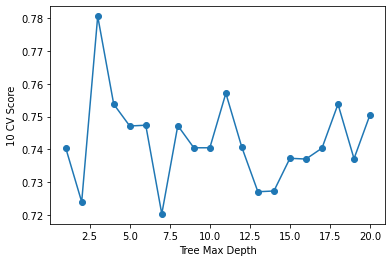

In [17]:
plt.plot(list(score_dict.keys()),list(score_dict.values()),marker = 'o')
plt.xlabel('Tree Max Depth')
plt.ylabel('10 CV Score')

In [18]:
# the best performane is when max tree deoth is 10
cls = DecisionTreeClassifier(max_depth=10)
cls.fit(X,y)

DecisionTreeClassifier(max_depth=10)

In [19]:
print(np.mean(cross_val_score(cls,X,y,cv=5)))

0.7436723163841807


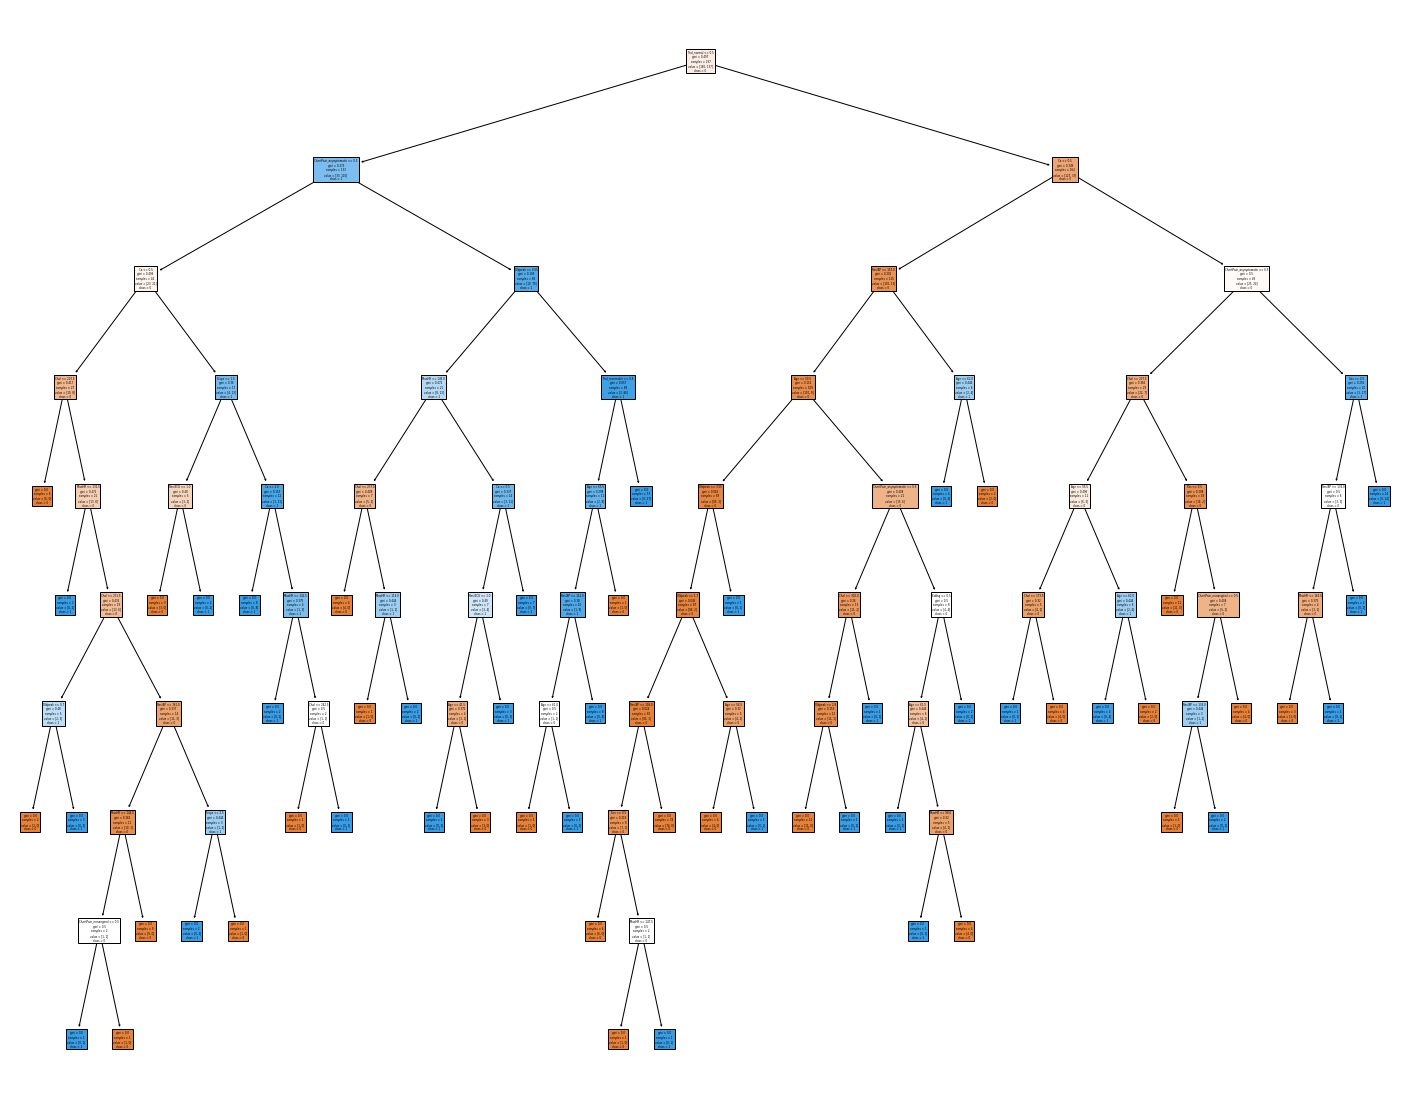

In [21]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(cls, feature_names=X.columns, class_names=['0','1'], filled=True)

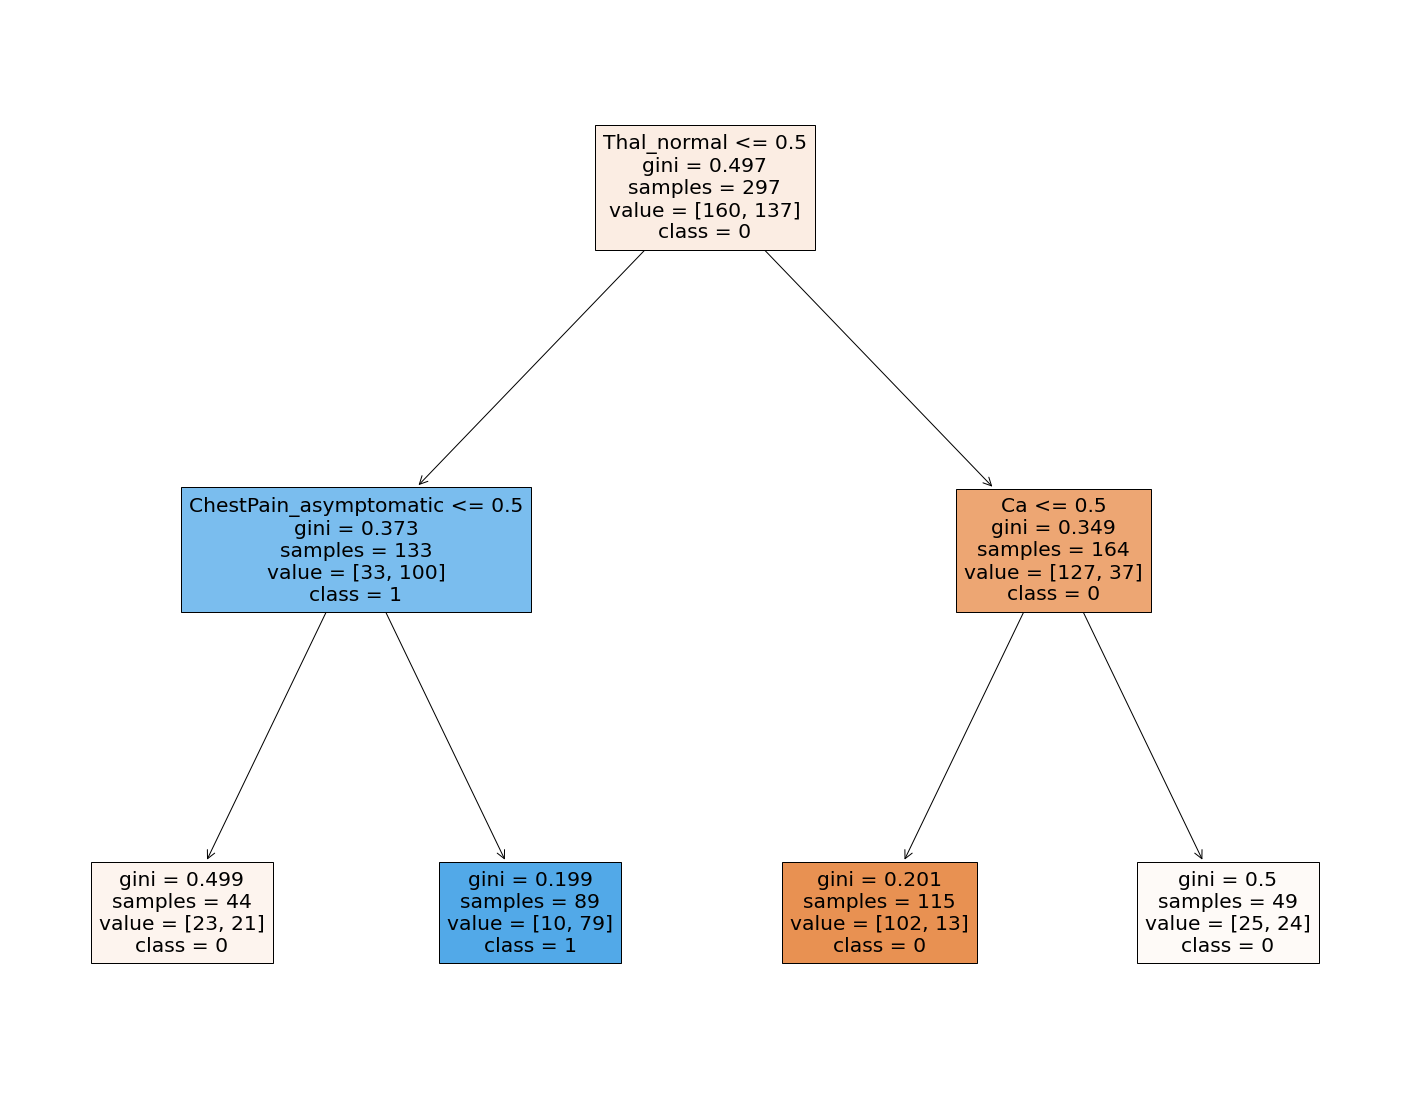

In [23]:
# the best performane is when max tree deoth is 10
cls = DecisionTreeClassifier(max_depth=2)
cls.fit(X,y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(cls, feature_names=X.columns, class_names=['0','1'], filled=True)

# Bagging classifier

In [24]:
from tqdm import tqdm
oob_dict = {}
for tree_size in tqdm(np.arange(10,1000,10)):    
  base_clf = DecisionTreeClassifier()
  bagging_model = BaggingClassifier(base_estimator=base_clf, n_estimators=1000, oob_score=True)
  bagging_model.fit(X,y)
  oob_dict[tree_size] = bagging_model.oob_score_

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [02:27<00:00,  1.49s/it]


Text(0, 0.5, 'OOB Score')

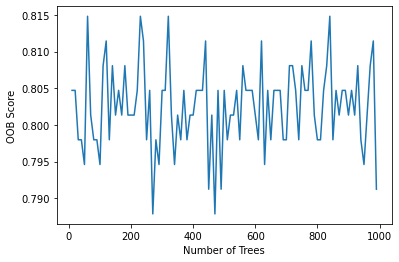

In [25]:
plt.plot(list(oob_dict.keys()),list(oob_dict.values()))
plt.xlabel('Number of Trees')
plt.ylabel('OOB Score')

In [26]:
feature_importances = np.mean([tree.feature_importances_ for tree in bagging_model.estimators_], axis=0)


In [27]:
feature_importances

array([0.08362392, 0.02552864, 0.06474974, 0.07634815, 0.00506295,
       0.0118833 , 0.09018331, 0.02379233, 0.09508868, 0.0278103 ,
       0.13772607, 0.13580654, 0.011571  , 0.00437879, 0.00847046,
       0.00242481, 0.16338328, 0.03216775])

## Feature Importance

<AxesSubplot:>

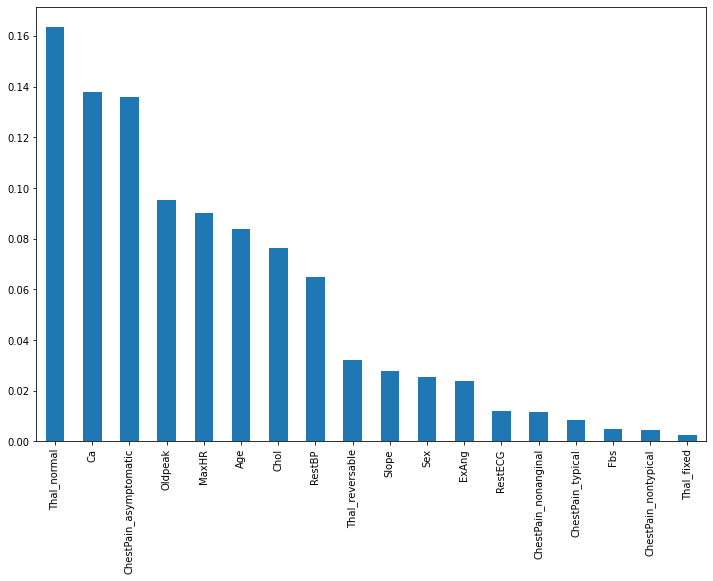

In [28]:
pd.Series(feature_importances,index = X.columns).sort_values(ascending=False).plot.bar(figsize = (12,8))

# Random Forests

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [29]:
from tqdm import tqdm
oob_dict_rf = {}
for tree_size in tqdm(np.arange(10,1000,10)):    
  rf = RandomForestClassifier(n_estimators=tree_size,oob_score=True)
  rf.fit(X,y)
  oob_dict_rf[tree_size] = rf.oob_score_

  0%|                                                                                           | 0/99 [00:00<?, ?it/s]d:\miniconda\install\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
d:\miniconda\install\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:54<00:00,  1.82it/s]


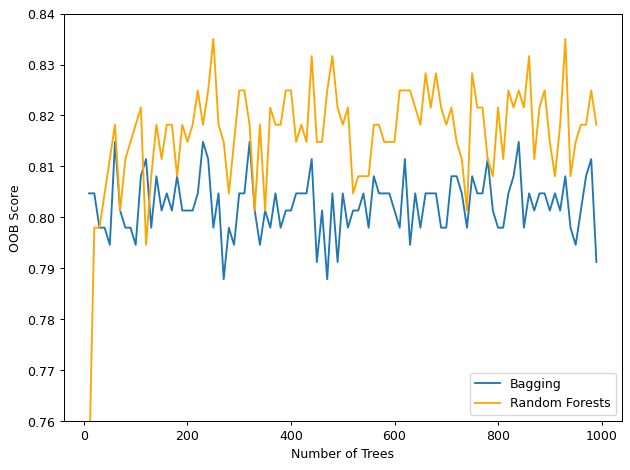

In [31]:
plt.figure(figsize=(8, 6), dpi=90)
plt.plot(list(oob_dict.keys()),list(oob_dict.values()),label = 'Bagging')
plt.plot(list(oob_dict_rf.keys()),list(oob_dict_rf.values()),label = 'Random Forests',color = 'orange')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Score')
plt.ylim(0.76,0.84)
plt.legend()

## Feature Importance

<AxesSubplot:>

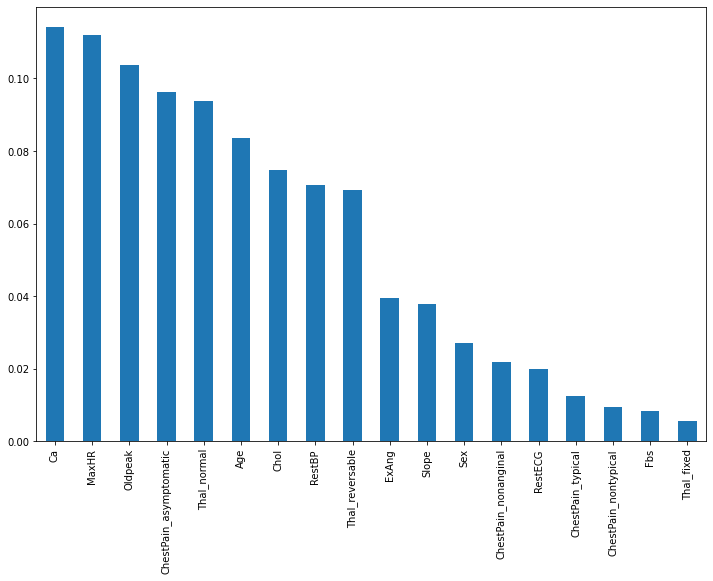

In [32]:
pd.Series(rf.feature_importances_,index = X.columns).sort_values(ascending=False).plot.bar(figsize = (12,8))

# Boosting

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

In [34]:
#depth = 1
from tqdm import tqdm
scores_dict_depth_1 = {}
for tree_size in tqdm(np.arange(10,1000,10)): 
  base_clf = DecisionTreeClassifier(max_depth=1)
  boost = AdaBoostClassifier(base_clf,n_estimators=tree_size)
  boost.fit(X_train,y_train)
  scores_dict_depth_1[tree_size] = 1 - boost.score(X_test,y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:46<00:00,  2.12it/s]


In [35]:
#depth = 2
from tqdm import tqdm
scores_dict_depth_2 = {}
for tree_size in tqdm(np.arange(10,1000,10)): 
  base_clf = DecisionTreeClassifier(max_depth=2)
  boost = AdaBoostClassifier(base_clf,n_estimators=tree_size)
  boost.fit(X_train,y_train)
  scores_dict_depth_2[tree_size] = 1 - boost.score(X_test,y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:51<00:00,  1.92it/s]


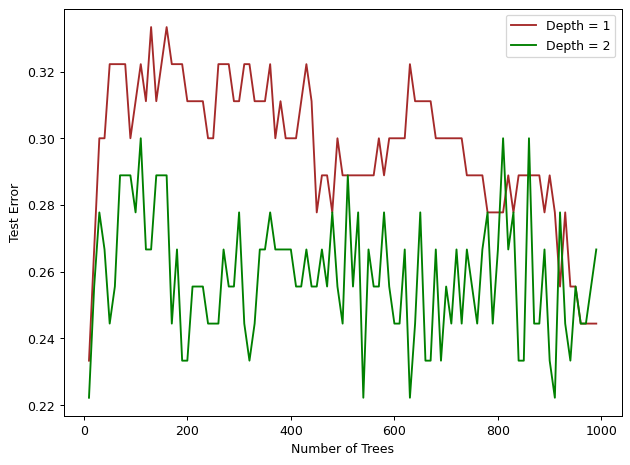

In [36]:
plt.figure(figsize=(8, 6), dpi=90)
plt.plot(list(scores_dict_depth_1.keys()),list(scores_dict_depth_1.values()),label = 'Depth = 1',color = 'brown')
plt.plot(list(scores_dict_depth_2.keys()),list(scores_dict_depth_2.values()),label = 'Depth = 2',color = 'green')
plt.xlabel('Number of Trees')
plt.ylabel('Test Error')
plt.legend()

# Happy Learning :)